# Embedding text

This notebook is inspired and in parts adapted from this excellent blog post: https://huggingface.co/blog/ngxson/make-your-own-rag

Here we show how any text (words, sentences, entire paragraphs) can be represented mathematically as a vector, and sentences of similar meaning correspond to vectors pointing in similar directions. This requires an embedding model, which here is `nomic-embed-text:latest` called through `ollama`.

In [1]:
import requests
import ollama

import umap
import matplotlib.pyplot as plt

# to avoid some UMAP warnings:
import warnings
warnings.filterwarnings("ignore")

EMBEDDING_MODEL = "nomic-embed-text:latest"

## Reading and embedding cat facts

In [2]:
cat_facts_url = (
    "https://huggingface.co/ngxson/demo_simple_rag_py/raw/main/cat-facts.txt"
)
response = requests.get(cat_facts_url)
cat_facts = response.text.split("\n")
print(cat_facts[0])

On average, cats spend 2/3 of every day sleeping. That means a nine-year-old cat has been awake for only three years of its life.


**Note:**
The next cell uses the `ollama` package, and will raise an error if you don't have Ollama running in the background (open with the GUI, or started with `ollama serve` in the terminal).

In [3]:
embedded_fact = ollama.embed(model=EMBEDDING_MODEL, input=cat_facts[0])
print(
    "This text was converted to a vector of dimension:",
    len(embedded_fact["embeddings"][0]),
)

This text was converted to a vector of dimension: 768


Let's embed all the facts, and keep the embedding stored in a list:

In [4]:
%%time
EMBEDDED_FACTS = []

for fact in cat_facts:
    EMBEDDED_FACTS.append(
        ollama.embed(model=EMBEDDING_MODEL, input=fact)["embeddings"][0]
    )

CPU times: user 40.3 ms, sys: 4.93 ms, total: 45.2 ms
Wall time: 2.16 s


I am also going to embed facts about computers, to see where they end up being embedded:

In [5]:
computer_facts = """The first modern computer was basically a giant calculator.
Computers work through special instructions called algorithms.
Phones are computers.
A computers memory is called RAM.
The Fugaku supercomputer in Japan can do 442 quadrillion calculations per second.""".split(
    "\n"
)
for fact in computer_facts:
    EMBEDDED_FACTS.append(
        ollama.embed(model=EMBEDDING_MODEL, input=fact)["embeddings"][0]
    )

## Visualising the embedding

Since each piece of text gets summarised as a point in a 768-dimension space, the embedding itself is difficult to visualise. Here I use UMAP to flatten it into a 2D space.

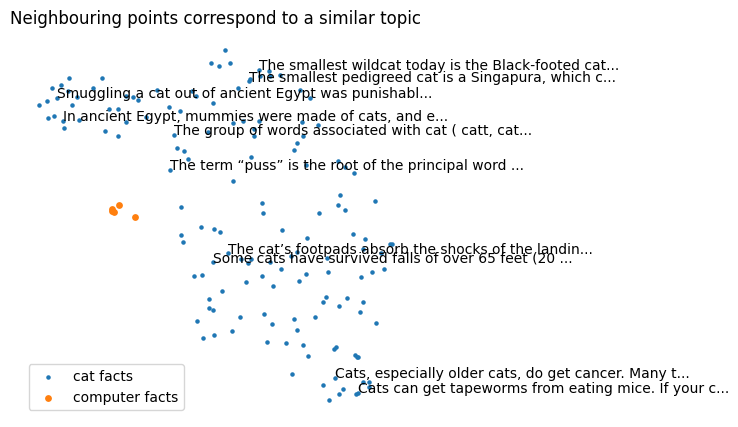

In [6]:
facts_2d = umap.UMAP(metric="cosine", random_state=0).fit_transform(EMBEDDED_FACTS)


plt.figure(figsize=(5, 5))
plt.title("Neighbouring points correspond to a similar topic")

plt.scatter(facts_2d[:, 0], facts_2d[:, 1], s=5, label="cat facts")
plt.scatter(facts_2d[150:, 0], facts_2d[150:, 1], s=15, label="computer facts")
plt.legend()

plt.gca().set_axis_off()
# write a few of the facts:
for i_fact in [15, 16, 126, 118, 28, 141, 31, 36, 109, 22]:
    plt.text(facts_2d[i_fact, 0], facts_2d[i_fact, 1], cat_facts[i_fact][:50] + "...")

# for i_fact in range(len(cat_facts)):
#    plt.text(facts_2d[i_fact,0], facts_2d[i_fact,1], str(i_fact))

## Retrieving information

If you need to answer a question, you can simply embed your question and look at the nearby pieces of information in embedded space. It is common to use a cosine distance, which is equal to a dot product between unit vectors. In semantic search, we usually care more about vectors pointing in the sane direction (same topic, same idea) than having the same length (same intensity).

In [7]:
def cosine_similarity(a, b):
    dot_product = sum([x * y for x, y in zip(a, b)])
    norm_a = sum([x**2 for x in a]) ** 0.5
    norm_b = sum([x**2 for x in b]) ** 0.5
    return dot_product / (norm_a * norm_b)

In [8]:
question = "Can cats catch illnesses?"
query_embedding = ollama.embed(model=EMBEDDING_MODEL, input=question)["embeddings"][0]

We now compare this embedded question against every embedded piece of information:

In [9]:
%%time
similarities = []

for chunk, embedding in zip(cat_facts, EMBEDDED_FACTS):
    similarity = cosine_similarity(query_embedding, embedding)
    similarities.append((chunk, similarity))

similarities.sort(key=lambda x: x[1], reverse=True)

print("Top 5 most relevant chunks:\n")
for chunk in similarities[:5]:
    print(chunk, "\n")

Top 5 most relevant chunks:

('A form of AIDS exists in cats.', 0.7515334103645988) 

('Though rare, cats can contract canine heart worms.', 0.7442833426220167) 

('Many people fear catching a protozoan disease, Toxoplasmosis, from cats. This disease can cause illness in the human, but more seriously, can cause birth defects in the unborn. Toxoplasmosis is a common disease, sometimes spread through the feces of cats. It is caused most often from eating raw or rare beef. Pregnant women and people with a depressed immune system should not touch the cat litter box. Other than that, there is no reason that these people have to avoid cats.', 0.7248480833524961) 

('Cats can get tapeworms from eating mice. If your cat catches a mouse it is best to take the prize away from it.', 0.7229536290194394) 

('Cats can get tapeworms from eating fleas. These worms live inside the cat forever, or until they are removed with medication. They reproduce by shedding a link from the end of their long bodies